<a href="https://colab.research.google.com/github/sonia-UoC/Diet_Classification_Fastai/blob/main/Diet_Classification_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -Uqq fastbook
import fastai
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.2MB 51.3MB/s 
     |████████████████████████████████| 204kB 49.7MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.vision.widgets import *

### Loading the dataset

In [ ]:
path ='gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images'

In [ ]:
# Checking the number of image files
fns = get_image_files(path)
fns

(#997) [Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/129543.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/88381.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/171599.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/215830.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/81425.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/876.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/246145.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/216506.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chicken_curry/181852.jpg'),Path('gdrive/My Drive/Colab Notebooks/Data/images/modified_food-101/images/chic

In [ ]:
# Verifying the number of corrupted images
failed = verify_images(fns)
failed

(#0) []

### Data splitting & Resizing using Fastai Data Block API and DataLoaders

*DataLoaders is a thin class that just stores whatever DataLoader objects are passed to it, and makes them available as train and valid. It provides the data for the model.*

In [ ]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [ ]:
# Creating Training and Validation Set using Fastai Data Block API
foods = DataBlock(blocks=(ImageBlock, CategoryBlock), get_items=get_image_files, 
  splitter=RandomSplitter(valid_pct=0.2, seed=42), get_y=parent_label, item_tfms=Resize(224))

In [ ]:
# DataBlock Object
dls = foods.dataloaders(path)

### Visualization of random images

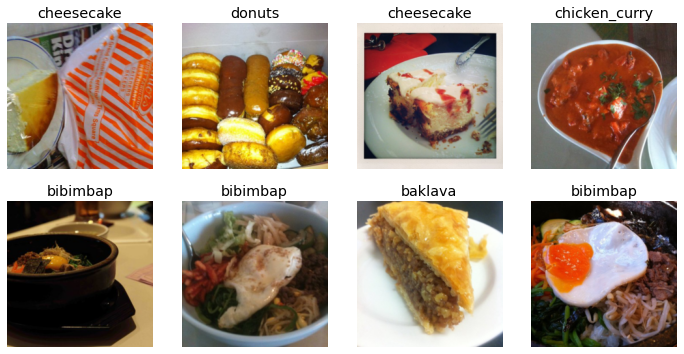

In [ ]:
dls.valid.show_batch(max_n=8, nrows=2)

### Data Preprocessing

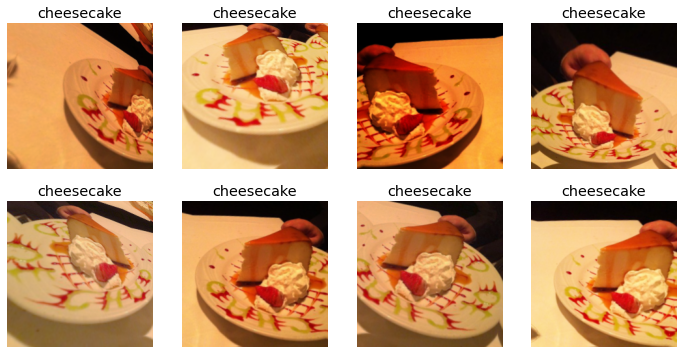

In [ ]:
# Data Augmentation
foods = foods.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
dls = foods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

### Model Training and Cleaning the data

In [ ]:
# Image standardization using RandomResizedCrop with an image size of 224 pixels
foods = foods.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms())
dls = foods.dataloaders(path)

In [ ]:
# Training the dataset using CNN model with transfer learning (Resnet18 Model)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
#learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,3.357846,1.906734,0.633166,02:41


epoch,train_loss,valid_loss,error_rate,time
0,1.825667,1.456522,0.472362,00:07
1,1.566444,1.160331,0.351759,00:07
2,1.353166,1.042221,0.306533,00:07
3,1.113513,1.061781,0.291457,00:07
4,0.920594,0.977688,0.276382,00:07
5,0.763146,1.015682,0.286432,00:07
6,0.644723,1.011433,0.301508,00:07
7,0.562770,0.984593,0.286432,00:07
8,0.490768,0.986580,0.271357,00:07
9,0.428555,0.992042,0.276382,00:07


* It's clear that after 30 epochs, the losses have reduced significantly. That means the model is not over fitted and we have got 73% accuracy approximately.

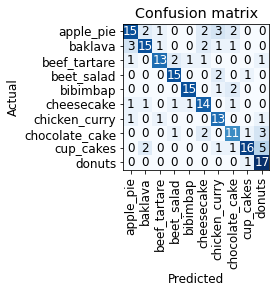

In [ ]:
# Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

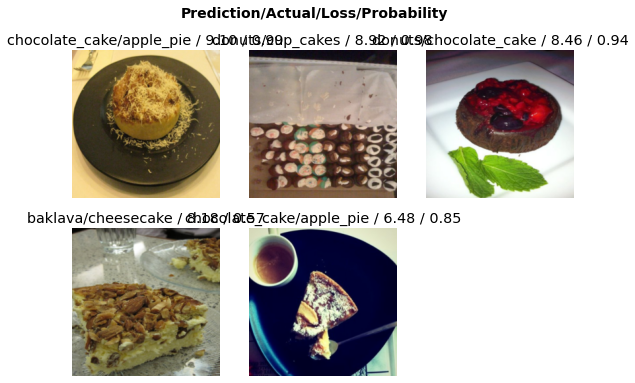

In [ ]:
# Visualization of the images with the highest loss in the dataset
interp.plot_top_losses(5, nrows=2)

In [ ]:
# Removing highest-loss images
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
# Training the model after removing the highest-loss images
learn = cnn_learner(dls, resnet18, metrics=error_rate)
#learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,3.024095,1.609979,0.557789,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.806246,1.350749,0.467337,00:07
1,1.541485,1.154501,0.402010,00:07
2,1.322022,1.039711,0.361809,00:08
3,1.103735,0.955464,0.306533,00:07
4,0.912785,0.932303,0.311558,00:07
5,0.754022,0.913124,0.291457,00:07
6,0.643789,0.903283,0.256281,00:07
7,0.548608,0.909364,0.271357,00:08
8,0.480175,0.902460,0.276382,00:08
9,0.422780,0.898550,0.286432,00:07


* After removing the highest-loss images, the losses have reduced more compare to the previous training values.

### Using the Model for Inference

In [ ]:
# Creating a .pkl file
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
# Creating the inference learner from the exported file
learn_inf = load_learner(path/'export.pkl')

### Prediction

In [ ]:
result= learn_inf.predict('/content/gdrive/MyDrive/Colab Notebooks/Data/images/modified_food-101/images/bibimbap/601.jpg')
result

('bibimbap',
 tensor(4),
 tensor([3.4177e-04, 7.6774e-04, 5.1445e-02, 1.8385e-03, 9.3082e-01, 8.6219e-03, 2.1926e-03, 2.4572e-03, 1.4434e-03, 6.9928e-05]))

* The system has predictated and identified the image correctly.

In [ ]:
# Loading Food diet dictionary
import pandas as pd

path_csv = 'gdrive/My Drive/Colab Notebooks/Data/food101.csv'
df = pd.read_csv(path_csv)
print(df)

         apple_pie        renal soft
0   baby_back_ribs             mixed
1          baklava               NaN
2   beef_carpaccio             mixed
3     beef_tartare              soft
4       beet_salad        renal soft
..             ...               ...
95           tacos               NaN
96        takoyaki               NaN
97        tiramisu        renal soft
98    tuna_tartare              soft
99         waffles  renal soft mixed

[100 rows x 2 columns]


In [ ]:
import csv

file = 'gdrive/My Drive/Colab Notebooks/Data/food101.csv'

with open(file, 'r') as f:
        food_diet_dict = dict (filter(None, csv.reader(f)))

print("Food:", result[0], ":", food_diet_dict[result[0]])

Food: bibimbap : renal soft


In [ ]:
path = Path()
learn_inf = load_learner(path/'export.pkl', cpu=True)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [ ]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    print("Food:", pred, ":", food_diet_dict[pred])

In [ ]:
btn_upload.observe(on_data_change, names=['data'])

In [ ]:
display(VBox([widgets.Label('Select your image!'), btn_upload, out_pl, lbl_pred]))

Food: beef_tartare : soft


In [ ]:
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 1.6MB 7.6MB/s 
     |████████████████████████████████| 122kB 51.3MB/s 
     |████████████████████████████████| 552kB 52.5MB/s 
     |████████████████████████████████| 389kB 46.8MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
ERROR: jupyter-server 1.8.0 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
